### Installing neccessary packages:

In [3]:
!pip install transformers
# https://huggingface.co/transformers/installation.html
!pip install sentencepiece
# https://pypi.org/project/sentencepiece/
# Python wrapper for SentencePiece. This API will offer the encoding, decoding and training of Sentencepiece.
!pip install Cython
# https://pypi.org/project/Cython/

     |████████████████████████████████| 3.1 MB 12.0 MB/s 
     |████████████████████████████████| 895 kB 31.4 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 596 kB 41.4 MB/s 
     |████████████████████████████████| 61 kB 508 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 12.5 MB/s 


## Checking the GPU availabilty

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the required packages:

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
import os
import sys
from transformers.optimization import Adafactor 
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import torch
import random
import re

os.chdir('/content/drive/MyDrive/NLP_Final_Project')

In [53]:
import pandas as pd
# Reading csv
data = pd.read_csv('data_10e_full_v1.csv')
print(data.head(5))

                                              inputs  ... sumlen
0  The sum of 1 10e3 4 10e2 0 10e1 6 10e0 and 7 1...  ...      4
1  The sum of 1 10e3 6 10e2 1 10e1 6 10e0 and 1 1...  ...      4
2  The sum of 3 10e2 7 10e1 6 10e0 and 1 10e3 6 1...  ...      4
3  The sum of 1 10e3 0 10e2 3 10e1 1 10e0 and 4 1...  ...      4
4  The sum of 1 10e3 3 10e2 6 10e1 3 10e0 and 5 1...  ...      4

[5 rows x 5 columns]


In [60]:
data_ood1 = pd.read_csv('10e_5digits_ood_v1.csv')
print(data.head(5))

                                              inputs  ... target_str
0  The sum of 3 10e1 4 10e0 and 6 10e2 3 10e1 2 1...  ...        NaN
1  The sum of 6 10e2 9 10e1 5 10e0 and 9 10e2 7 1...  ...        NaN
2  The sum of 2 10e2 7 10e1 4 10e0 and 1 10e3 6 1...  ...        NaN
3  The sum of 1 10e2 2 10e1 8 10e0 and 4 10e2 4 1...  ...        NaN
4  The sum of 1 10e3 5 10e2 4 10e1 7 10e0 and 9 1...  ...        NaN

[5 rows x 7 columns]


In [61]:
data = data.sample(n = 11700, random_state = 42).reset_index(drop=True)
data_ood = data_ood1.sample(n = 1300, random_state = 42).reset_index(drop=True)

In [55]:
data = data.append(data_ood, ignore_index=True)

In [56]:
data = data.sample(frac=1).reset_index(drop=True)
print(len(data))

13000


In [57]:
from sklearn.model_selection import train_test_split

# Test and validation split
train, validation = train_test_split(data, test_size=0.2, random_state=42)
train, test = train_test_split(train, test_size=0.3, random_state=42)

data_train = train.reset_index(drop=True)
data_valid = validation.reset_index(drop=True)
data_test = test.reset_index(drop=True)

In [17]:
data_train.shape

(7280, 5)

In [18]:
data_valid.shape

(2600, 5)

In [19]:
data_test.shape

(3120, 5)

In [20]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 32
num_of_batches = int(len(data_train)/batch_size)

In [21]:
# Reference
# https://huggingface.co/transformers/model_doc/t5.html
# https://medium.com/analytics-vidhya/t5-a-detailed-explanation-a0ac9bc53e51
# https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45

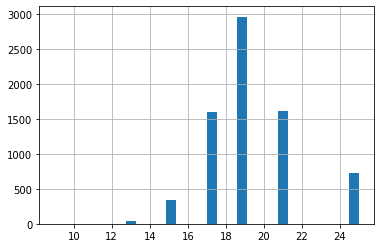

In [22]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [23]:
# T5-base
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
# moving the model to device(GPU/CPU)
model.to(device)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [24]:
token_lens = []

for txt in data_train.inputs:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

max(token_lens)

50

In [25]:
token_lens_target = []

for txt in data_train.target:
  # doubt
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens_target.append(len(tokens))

max(token_lens_target)

23

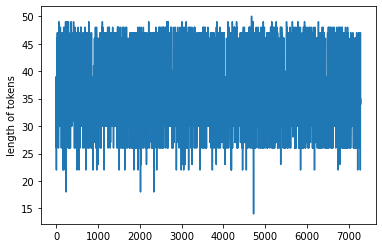

Maximum length is:  50


In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 14

In [27]:
MAX_LEN = 55

In [28]:
def get_word_embeddings(data, MAX_LEN=55):
  input_ids=[]
  attention_masks = []
  for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

  # Convert lists to tensors
  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  return input_ids, attention_masks

In [29]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = get_word_embeddings(data_train['inputs'])
val_inputs, val_masks = get_word_embeddings(data_valid['inputs'])
test_inputs, test_masks = get_word_embeddings(data_test['inputs'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
data_train['target_str'] = data_train['target'].astype(str)
data_valid['target_str'] = data_valid['target'].astype(str)
data_test['target_str'] = data_test['target'].astype(str)

In [31]:
#convert lists to tensors
train_labels = get_word_embeddings(data_train['target_str'], 30)[0]
val_labels = get_word_embeddings(data_valid['target_str'], 30)[0]
test_labels = get_word_embeddings(data_test['target_str'], 30)[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [32]:
train_labels.shape
# doubt

torch.Size([7280, 30])

In [33]:
train_labels

tensor([[209, 335,  15,  ...,   0,   0,   0],
        [209, 335,  15,  ...,   0,   0,   0],
        [204, 335,  15,  ...,   0,   0,   0],
        ...,
        [204, 335,  15,  ...,   0,   0,   0],
        [209, 335,  15,  ...,   0,   0,   0],
        [209, 335,  15,  ...,   0,   0,   0]])

In [34]:
data_train['target']

0              1 10e3 8 10e2 8 10e1 4 10e0
1              1 10e3 7 10e2 2 10e1 1 10e0
2              2 10e3 9 10e2 4 10e1 8 10e0
3              2 10e3 6 10e2 1 10e1 2 10e0
4              1 10e3 2 10e2 7 10e1 3 10e0
                       ...                
7275           2 10e3 7 10e2 5 10e1 0 10e0
7276    5 10e4 7 10e3 8 10e2 6 10e1 3 10e0
7277           2 10e3 3 10e2 5 10e1 3 10e0
7278           1 10e3 7 10e2 2 10e1 4 10e0
7279           1 10e3 7 10e2 7 10e1 3 10e0
Name: target, Length: 7280, dtype: object

In [35]:
train_inputs.shape

torch.Size([7280, 55])

In [36]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [37]:
#  Optimizer
# https://huggingface.co/transformers/model_doc/t5.html#overview
optimizer = Adafactor(
    model.parameters(),
    lr=3e-4, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.5,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [38]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/MyDrive/Colab Notebooks/new_run')
# print(os.getcwd())

In [2]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2021-12-05 00:19:40--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.105.197
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.105.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-12-05 00:19:40 (35.7 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



In [40]:
from IPython.display import HTML, display

# Setting the progress, with html as UI.
def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [39]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    v_accuracy = []
    v_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        
        v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in batch)

        # print(v_input_ids.shape, v_labels.shape)

        val_outputs = model.generate(input_ids=v_input_ids, attention_mask=v_attn_mask)

        val_preds = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in val_outputs]

        val_labels = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in v_labels]
        
        # v_loss.append(val_outputs.loss)

        # Get the predictions
        # print(val_outputs.logits.shape)
        # val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        # print(val_preds, val_labels)
        # Calculate the accuracy rate

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        accuracy = ((val_preds == val_labels).sum() / len(val_labels)) * 100
        v_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    # v_loss = np.mean(v_loss)
    v_accuracy = np.mean(v_accuracy)

    return v_accuracy

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  running_loss=0
  # out = display(progress(1, num_of_batches+1), display_id=True)
  i =0 
  for batch in train_dataloader:
    
    input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()
    gc.collect()
    torch.cuda.empty_cache()

    # Forward propogation
    # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
    outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
    
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    # out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    # updating the params
    optimizer.step()

    print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
    i += 1

  running_loss = running_loss/len(train_dataloader)
  # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
  curr_accuracy = evaluate(model, val_dataloader)

  # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
  print("-"*70)

  if curr_accuracy > val_acc:
    val_acc = curr_accuracy
    # Saving the best model
    torch.save(model.state_dict(),'FineTune_10e_Model_32eph_v2_10perc_bias.bin')


Streaming output truncated to the last 5000 lines.
Epoch  4 Batch  78 / 228  Training Loss  0.014985546469688416
Epoch  4 Batch  79 / 228  Training Loss  0.004447310231626034
Epoch  4 Batch  80 / 228  Training Loss  0.03369537740945816
Epoch  4 Batch  81 / 228  Training Loss  0.017536189407110214
Epoch  4 Batch  82 / 228  Training Loss  0.0069676837883889675
Epoch  4 Batch  83 / 228  Training Loss  0.009135553613305092
Epoch  4 Batch  84 / 228  Training Loss  0.009853671304881573
Epoch  4 Batch  85 / 228  Training Loss  0.00746605871245265
Epoch  4 Batch  86 / 228  Training Loss  0.006411363836377859
Epoch  4 Batch  87 / 228  Training Loss  0.00914064422249794
Epoch  4 Batch  88 / 228  Training Loss  0.01623951643705368
Epoch  4 Batch  89 / 228  Training Loss  0.01534426398575306
Epoch  4 Batch  90 / 228  Training Loss  0.02411000244319439
Epoch  4 Batch  91 / 228  Training Loss  0.015629298985004425
Epoch  4 Batch  92 / 228  Training Loss  0.010866420343518257
Epoch  4 Batch  93 / 228

In [ ]:
# Changing the directory to store the model there.
# print(os.getcwd())
# os.chdir('/content/drive/My Drive/Colab Notebooks/new/')

# print(os.getcwd())

#### Saving the Model (creating checkpoint)

In [ ]:
# PATH = "fine_tune_10e_20eph.pt"
# torch.save({
#             'epoch': num_of_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': running_loss,
#             }, PATH)

In [8]:
model_load = T5ForConditionalGeneration.from_pretrained('FineTune_10e_Model_32eph_v2_10perc_bias.bin', return_dict=True, config='t5-base-config.json')

In [9]:
model_load.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [41]:
evaluate(model_load, test_dataloader)

90.33801020408163

In [63]:
# Function to generate sentences from symptoms on the test dataset
def generateText(text):
  model_load.eval()
  input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
  # input_ids.to(dev)
  s = time.time()
  outputs = model_load.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  print('Generated in {} seconds'.format(str(elapsed)[:4]))

  return gen_text

In [64]:
data_ood = data_ood1.sample(n = 6000, random_state = 42).reset_index(drop=True)

In [65]:
data_ood['type'] = "OOD"

In [66]:
model_load.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
data_test['type'] = 'iid'
data_ood['target_str'] = data_ood['target'].astype(str)
bigdata = data_test.append(data_ood, ignore_index=True)
bigdata['predictions'] = bigdata.apply(lambda x: generateText(x['inputs']), axis=1)
bigdata.to_csv('10e_results_10perc_bias.csv', index = False, header=None)

Generated in 1.40 seconds
Generated in 1.46 seconds
Generated in 1.41 seconds
Generated in 1.40 seconds
Generated in 1.42 seconds
Generated in 1.38 seconds
Generated in 1.08 seconds
Generated in 1.40 seconds
Generated in 1.41 seconds
Generated in 1.37 seconds
Generated in 1.51 seconds
Generated in 1.39 seconds
Generated in 1.38 seconds
Generated in 1.40 seconds
Generated in 1.41 seconds
Generated in 1.59 seconds
Generated in 1.40 seconds
Generated in 1.07 seconds
Generated in 1.40 seconds
Generated in 1.49 seconds
Generated in 1.42 seconds
Generated in 1.47 seconds
Generated in 1.46 seconds
Generated in 1.46 seconds
Generated in 1.40 seconds
Generated in 1.50 seconds
Generated in 1.36 seconds
Generated in 1.08 seconds
Generated in 1.09 seconds
Generated in 1.09 seconds
Generated in 1.40 seconds
Generated in 1.61 seconds
Generated in 1.42 seconds
Generated in 1.40 seconds
Generated in 1.40 seconds
Generated in 1.39 seconds
Generated in 1.40 seconds
Generated in 1.59 seconds
Generated in

In [ ]:
data_valid
# testing on this for now

,inputs,target,target_str
0,The sum of <extra_id_0>58 and 806 is 1564,7,7
1,The sum of 755 and 2<extra_id_0>1 is 1016,6,6
2,The sum of 864 and 95 is <extra_id_0>9,95,95
3,The sum of 263 and 915 is <extra_id_0>178,1,1
4,The sum of 569 and 460 is 1<extra_id_0>29,0,0
...,...,...,...
8995,The sum of 745 and 755 is 1<extra_id_0>0,50,50
8996,The sum of 131 and <extra_id_0>91 is 922,7,7
8997,The sum of 732 and 735 is <extra_id_0>467,1,1
8998,The sum of 4<extra_id_0>5 and 175 is 640,6,6


In [ ]:
generateText("The sum of 732 and 73<extra_id_0> is 1467") # example

Generated in 0.24 seconds


' 7'

In [ ]:
data_test['predictions'] = data_valid.apply(lambda x: generateText(x))
# should try this.

In [ ]:

def convert_to_10ebased(number: str, split_type: str, invert_number: bool) -> str:
    signal = None
    if number[0] == '-':
        signal = '-'
        number = number[1:]

    output = []
    for i, digit in enumerate(number[::-1]):
        if split_type is None:
            output.append('10e' + str(i))
        elif split_type == 'underscore':
            output.append('10e' + '_'.join(str(i)))
        elif split_type == 'character':
            output.append(' '.join('D' + str(i) + 'E'))
        else:
            raise Exception(f'Wrong split_type: {split_type}')
        output.append(digit)

    if signal:
        output.append(signal)

    # The output is already inverted. If we want it to _not_ be inverted, then we invert it.
    if not invert_number:
        output = output[::-1]

    return ' '.join(output)

In [ ]:
convert_to_10ebased(
                "932", split_type=None, invert_number=False)

'9 10e2 3 10e1 2 10e0'